In [1]:
from scipy.signal import peak_widths, find_peaks
import matplotlib.pyplot as plt
from tqdm.contrib.itertools import product
from memento import *
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Model Parameters

In [2]:
# Model Parameters
layer_sizes = [100, 100, 100, 100]  # Number of nodes in each layer    
kappas = [10, 10, 10]               # Kappa parameter for Von Mises functions for intra-layer weights
lateral_recurrence = 'cosine2'      # type of lateral recurrence

n_timesteps=500                     # Number of timesteps to simulate
stim_on = 500                       # Input duration

# Initialize the generic structure of the model for simulating feedforward and feedback
model = Memento(layer_sizes)        
model.W_ff_0 = 0.03                 # How much to scale the feedforward weights by (to avoid exploding activations)
model.W_fb_0 = 0.03                 # How much to scale the feedback weights by

# Simulate feedforward input condition 
### (aka 'bottom-up' or 'Perception') 

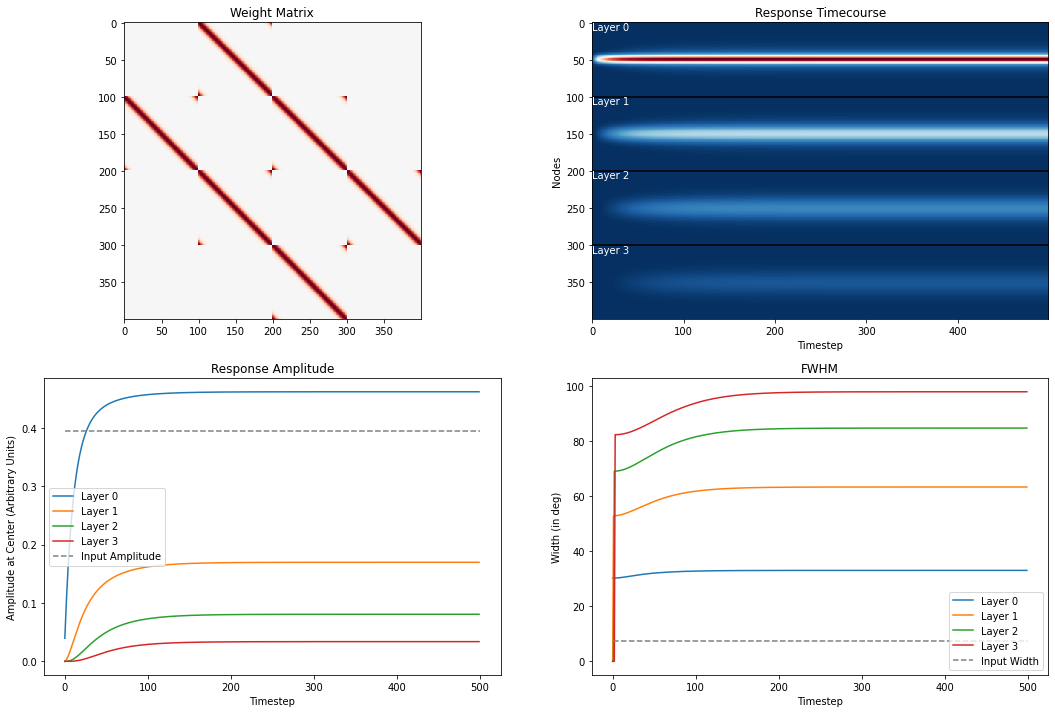

In [3]:
# Set all node activations to 0
model.reset()

# FEED FORWARD
# Initialize the weights
model.W_r_0 = [0, 0, 0, 0]
model.W, W_L = model.init_weights(plot = False, kappas = kappas, return_matrices=True, recurrence = lateral_recurrence)

# define feedforward (aka 'perception') input
k_input = 20
h = vonmises_input(model, k_input, input_layer = 'in')
h = h/np.linalg.norm(h)

# simulate
_, T_ff, W_ff, A_ff = simulate(model, n_timesteps, stim_on, h)

# Store top layer output to use for feedback later
r_top = np.expand_dims(T_ff[model.out_idx, -1], axis = 1)

# Plot model weight matrix and simulation results
model.plot(T_ff, h)

# Simulate feedback input condition 
### (aka 'top-down' or 'Memory') 

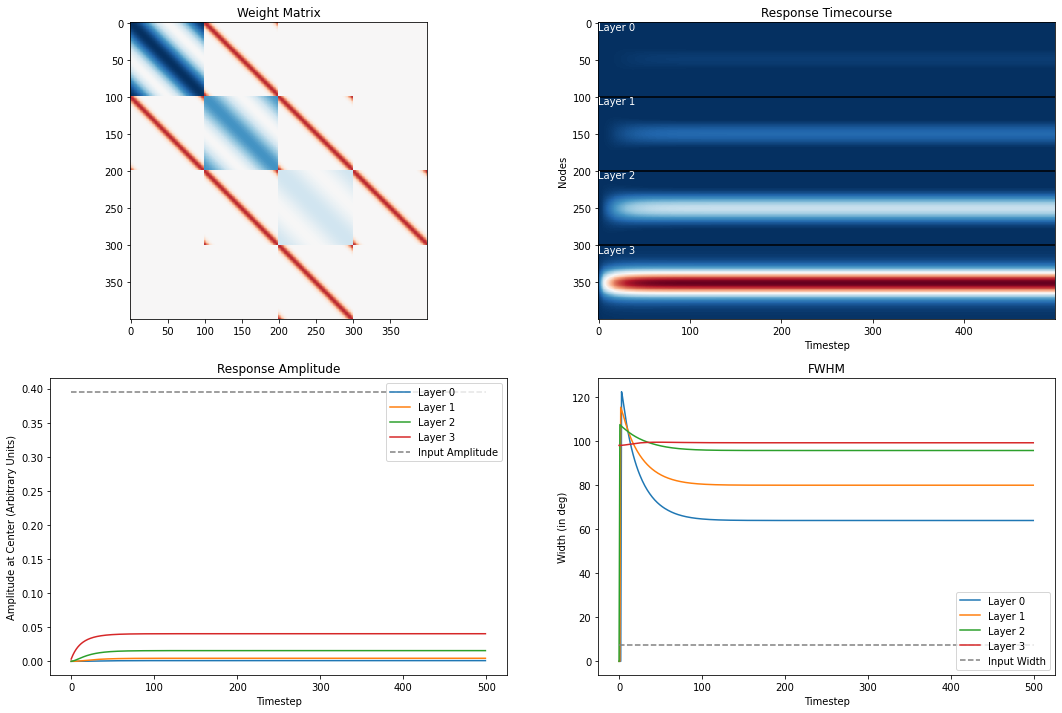

In [9]:
# Set all node activations to 0
model.reset()

## FEED BACK 
# Initialize the weights
model.W_r_0 = [-2.5, -1.5, -.5, -0]
model.W, W_L = model.init_weights(plot = False, kappas = kappas, return_matrices=True, recurrence = lateral_recurrence)

## feed back 
h_top = np.zeros_like(model.r)
h_top[model.out_idx] = r_top

# simulate
_, T_fb, W_fb, A_fb = simulate(model, n_timesteps, stim_on, h_top)

# Plot model weight matrix and simulation results
model.plot(T_fb, h)

# Compare 'Perception' vs. 'Memory'

Text(0.5, 0, 'Timesteps')

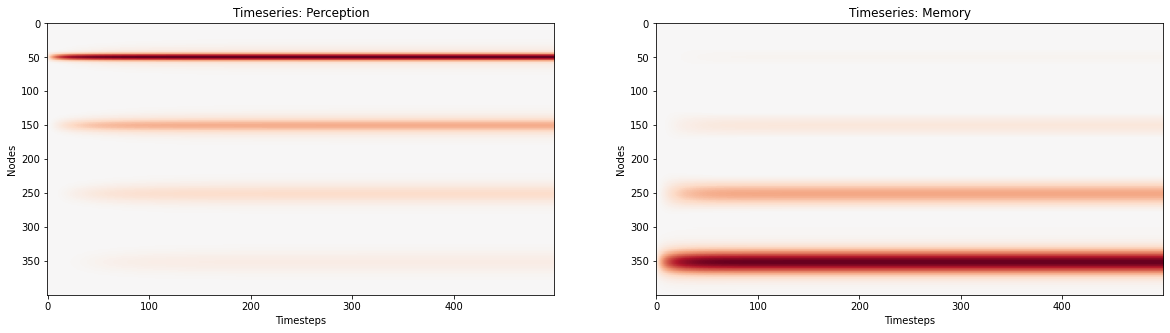

In [10]:
# Plot 2D Timeseries
fig, axs = plt.subplots(1, 2, figsize = [20, 5])

v_ff = np.abs(np.asarray([T_ff.min(), T_ff.max()])).max()
# axs[0].imshow(model.W, aspect = 'auto', interpolation = 'none')
bottomup = axs[0].imshow(T_ff, aspect = 'auto', interpolation = 'none', cmap = 'RdBu_r',vmin = -v_ff, vmax = v_ff)
v_fb = np.abs(np.asarray([T_fb.min(), T_fb.max()])).max()
topdown = axs[1].imshow(T_fb, aspect = 'auto', interpolation = 'none', cmap = 'RdBu_r', vmin = -v_fb, vmax = v_fb)

axs[0].set_title('Timeseries: Perception')
axs[1].set_title('Timeseries: Memory')

axs[0].set_ylabel("Nodes")
axs[1].set_ylabel("Nodes")
axs[0].set_xlabel("Timesteps")
axs[1].set_xlabel("Timesteps")


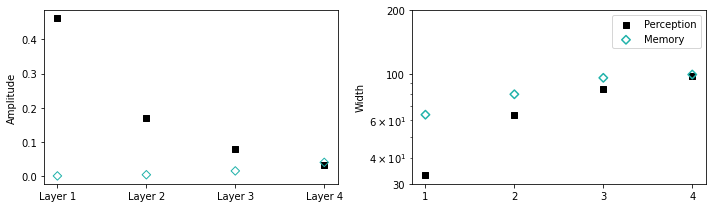

In [11]:
# Plot amplitude and tuning width at end of timeseries
fig, axs = plt.subplots(1, 2, figsize = [10, 3])

axs[1].scatter(x = range(len(model.layer_sizes)), y=W_ff[:, stim_on-1], label = 'Perception',
               color = 'black', marker = 's')
axs[1].scatter(x = range(len(model.layer_sizes)), y=W_fb[:, stim_on-1], label = 'Memory',
               facecolors = 'none', edgecolors = 'lightseagreen', marker = 'D', linewidth =1.5)
axs[0].scatter(x = range(len(model.layer_sizes)), y=A_ff[:, stim_on-1], label = 'Perception',
               color = 'black', marker = 's')
axs[0].scatter(x = range(len(model.layer_sizes)), y=A_fb[:, stim_on-1], label = 'Memory',
               facecolors = 'none',  edgecolors = 'lightseagreen', marker = 'D')


axs[1].set_ylim([30, 200])
axs[1].set_yscale('log')

axs[0].set_xticks([0, 1, 2, 3], ['Layer %d' % (d+1) for d in range(4)])
axs[1].set_xticks([0, 1, 2, 3], ['%d' % (d+1) for d in range(4)])
axs[1].set_yticks([30, 100, 200], [30, 100, 200])
axs[0].set_ylabel("Amplitude")
axs[1].set_ylabel("Width")
axs[1].legend()


plt.tight_layout()
plt.show()